In [2]:
# show plots inline in the notebook
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
import zeus
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
import numpy as np
import zeus
from sklearn.cluster import AgglomerativeClustering
from data_helper import load_umap_newsgroups
from tqdm import tqdm
from memoization import cached

plt.style.use("seaborn-darkgrid")

X_news, y_news = load_umap_newsgroups(sampling=10, n_components=10)


In [6]:

@cached
def get_rand_score(distance_threshold, X, y, eps=1e-3):
    predicted = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None).fit_predict(X)
    return eps + adjusted_rand_score(predicted, y)


distance_thresholds = np.arange(0,50, 0.2)
scores = [get_rand_score(distance_threshold, X_news, y_news) for distance_threshold in distance_thresholds]


In [17]:
def mcmc(steps, left=0, right=50):
    states = []
    current = np.random.uniform(left, right)
    for i in tqdm(range(steps)):
        states.append(current)
        movement = np.random.uniform(left, right)

        curr_prob = get_rand_score(distance_threshold=current, X=X_news, y=y_news)
        move_prob = get_rand_score(distance_threshold=movement, X=X_news, y=y_news)

        # Flip a coin to determine whether or not to move
        if np.random.uniform(0, 1) < min(move_prob / curr_prob, 1):
            current = movement
    return states[burn_in:]

steps = 1000
burn_in = int(steps * 0.2)
raw_samples = mcmc(steps)
samples = raw_samples[burn_in:]

100%|██████████| 1000/1000 [00:25<00:00, 38.50it/s]


Text(0, 0.5, 'Adjusted Rand Score Over 20 Newsgroups Dataset')

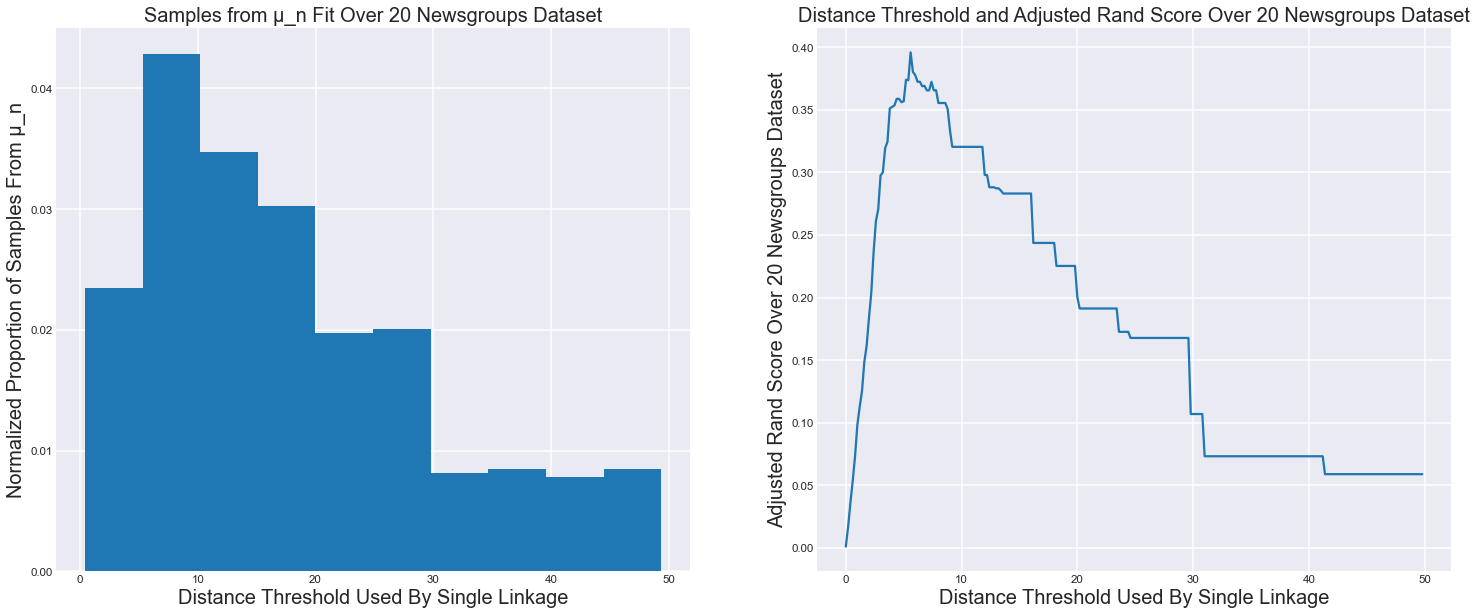

In [18]:
%matplotlib inline

plt.figure(figsize=(25,10))

plt.subplot(1,2,1)
plt.hist(samples, density=True)
plt.title("Samples from {}_n Fit Over 20 Newsgroups Dataset".format(chr(956)), fontsize=20)
plt.xlabel("Distance Threshold Used By Single Linkage", fontsize=20)
plt.ylabel("Normalized Proportion of Samples From {}_n".format(chr(956)), fontsize=20)

plt.subplot(1,2,2)
plt.plot(distance_thresholds, scores)
plt.title("Distance Threshold and Adjusted Rand Score Over 20 Newsgroups Dataset", fontsize=20)
plt.xlabel("Distance Threshold Used By Single Linkage", fontsize=20)
plt.ylabel("Adjusted Rand Score Over 20 Newsgroups Dataset", fontsize=20)